
**Kaggle Api**


In [ ]:
!pip install kaggle

kaggle.json

In [ ]:
#configure the path of kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


Importing Twitter Sentimental dataset




In [ ]:
#API to fetch the datset from Kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
100% 80.9M/80.9M [00:03<00:00, 31.8MB/s]
100% 80.9M/80.9M [00:03<00:00, 24.3MB/s]


Extracting zip file

In [ ]:
#extracting the compressed datset
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


Importing the dependencies

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from wordcloud import WordCloud
import time

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#printing stopwords in english
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

##**Data processing**

In [ ]:
#loading the data from csv file to pandas datframe
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1')

In [ ]:
# checking the numbers of rows and cloumns
df.shape

(1599999, 6)

In [ ]:
#first five rows
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


Fixing columns names

In [ ]:
columns_name = ['target','ids','date','flag','user','text']
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',names=columns_name, encoding='ISO-8859-1')


In [ ]:
# checking the numbers of rows and cloumns
df.shape

(1600000, 6)

In [ ]:
#first five rows
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


missing values

In [ ]:
#counting the missing values in the dataset
df.isnull().sum()

,0
target,0
ids,0
date,0
flag,0
user,0
text,0


In [ ]:
#checking the distribution of target columns
df['target'].value_counts()

,count
target,
0,800000
4,800000


Convert the target "4" to "1"

In [ ]:
df.replace({'target':{4:1}},inplace=True)

In [ ]:
#checking the distribution of target columns
df['target'].value_counts()

,count
target,
0,800000
1,800000


0--> negative tweet

1 --> positive tweet



**Stemming**

In [ ]:
port_stem = PorterStemmer()

In [ ]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]',' ',content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content


In [ ]:
df['stemmed_content'] = df['text'].apply(stemming)

In [ ]:
df.head()

,target,ids,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [ ]:
print (df['stemmed_content'])

KeyError: 'stemmed_content'

In [ ]:
print(df['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [ ]:
# Data Analysis and Visualization
def analyze_data(df):
    print("Dataset Overview:")
    print("-----------------")
    print(f"Total Samples: {len(df)}")
    print(f"Positive Samples: {len(df[df['target'] == 1])}")
    print(f"Negative Samples: {len(df[df['target'] == 0])}")

    # Create word clouds for positive and negative tweets
    positive_text = ' '.join(df[df['target'] == 1]['stemmed_content'])
    negative_text = ' '.join(df[df['target'] == 0]['stemmed_content'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Positive WordCloud
    wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
    ax1.imshow(wordcloud_pos)
    ax1.axis('off')
    ax1.set_title('Common Words in Positive Tweets')

    # Negative WordCloud
    wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
    ax2.imshow(wordcloud_neg)
    ax2.axis('off')
    ax2.set_title('Common Words in Negative Tweets')

    plt.show()

Dataset Overview:
-----------------
Total Samples: 1600000
Positive Samples: 800000
Negative Samples: 800000


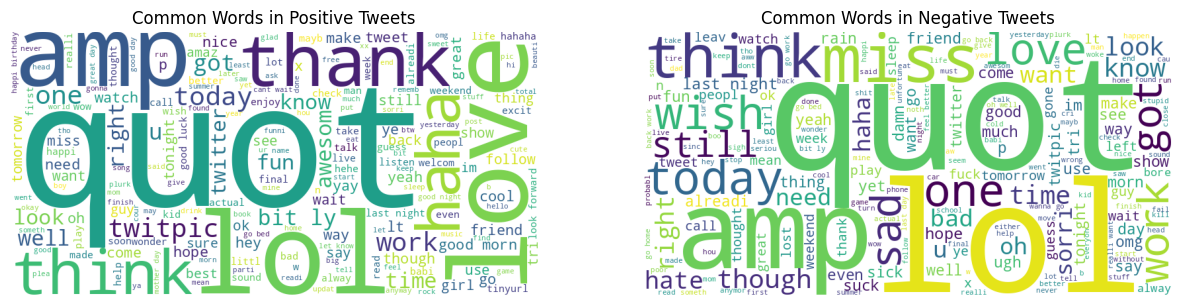

In [ ]:
analyze_data(df)

In [ ]:
#seperating the data and label
X = df['stemmed_content'].values
Y = df['target'].values

In [ ]:
print(X)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']


In [ ]:
print(Y)

[0 0 0 ... 1 1 1]


In [ ]:
#Splitting the data in to training data and test data
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=2)

In [ ]:
print(X.shape,X_train.shape,X_test.shape)

(1600000,) (1280000,) (320000,)


In [ ]:
print(X_train)

['watch saw iv drink lil wine' 'hatermagazin'
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 'hope everyon mother great day wait hear guy store tomorrow'
 'love wake folger bad voic deeper']


In [ ]:
#converting the textual data to numerical data
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
print(X_train)

  (0, 109306)	0.3753708587402299
  (0, 185193)	0.5277679060576009
  (0, 235045)	0.41996827700291095
  (0, 354543)	0.3588091611460021
  (0, 436713)	0.27259876264838384
  (0, 443066)	0.4484755317023172
  (1, 160636)	1.0
  (2, 77929)	0.3128408075034635
  (2, 109306)	0.45911764137283173
  (2, 124484)	0.18921559608014152
  (2, 129411)	0.2907419272795715
  (2, 132311)	0.20289715703997943
  (2, 150715)	0.1880385058320795
  (2, 178061)	0.1619010109445149
  (2, 266729)	0.24123230668976978
  (2, 288470)	0.16786949597862735
  (2, 406399)	0.32105459490875526
  (2, 407301)	0.18709338684973034
  (2, 409143)	0.15169282335109838
  (2, 433560)	0.32965958980285653
  (2, 443430)	0.33485996702528453
  (3, 56476)	0.5200465453608686
  (3, 151770)	0.278559647704793
  (3, 158711)	0.4456939372299574
  (3, 172421)	0.37464146922154384
  :	:
  (1279996, 291078)	0.17981734369155505
  (1279996, 318303)	0.21254698865277744
  (1279996, 373144)	0.35212500999832036
  (1279996, 390130)	0.2206474219107611
  (1279996, 412

In [ ]:
print(X_test)

  (0, 15110)	0.1719352837797837
  (0, 31168)	0.1624772418052177
  (0, 67828)	0.26800375270827315
  (0, 106069)	0.36555450010904555
  (0, 132364)	0.255254889555786
  (0, 138164)	0.23688292264071406
  (0, 171378)	0.2805816206356074
  (0, 271016)	0.45356623916588285
  (0, 279082)	0.17825180109103442
  (0, 388348)	0.2198507607206174
  (0, 398906)	0.34910438732642673
  (0, 409143)	0.3143047059807971
  (0, 420984)	0.17915624523539805
  (1, 6463)	0.30733520460524466
  (1, 15110)	0.211037449588008
  (1, 145393)	0.575262969264869
  (1, 217562)	0.40288153995289894
  (1, 256777)	0.28751585696559306
  (1, 348135)	0.4739279595416274
  (1, 366203)	0.24595562404108307
  (2, 22532)	0.3532582957477176
  (2, 34401)	0.37916255084357414
  (2, 89448)	0.36340369428387626
  (2, 183312)	0.5892069252021465
  (2, 256834)	0.2564939661498776
  :	:
  (319994, 443794)	0.2782185641032538
  (319995, 107868)	0.33399349737546963
  (319995, 109379)	0.3020896484890833
  (319995, 155493)	0.2770682832971669
  (319995, 2133

Traning the logistic regression model

In [ ]:
model = LogisticRegression(max_iter=1000)

In [ ]:
model.fit(X_train,Y_train)

LogisticRegression(max_iter=1000)

#**Model Evaluation**

Accuracy Score

In [ ]:
#accuracy score
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction,Y_train)

In [ ]:
print('Accuracy score on the training data: ', training_data_accuracy)

Accuracy score on the training data:  0.79871953125


In [ ]:
#accuracy on test score
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction,Y_test)

In [ ]:
print('Accuracy score on the test data: ', test_data_accuracy)

Accuracy score on the test data:  0.77668125


Visualisation

In [ ]:
# Model Evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    # Training time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Predictions
    y_pred = model.predict(X_test)

    # Performance metrics
    print(f"\n{model_name} Performance Metrics:")
    print("---------------------------------")
    print(f"Training Time: {training_time:.2f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print("\nCross-validation Scores:", cv_scores)
    print(f"Average CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")



Model Performance Metrics:
---------------------------------
Training Time: 19.60 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    160000
           1       0.77      0.80      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



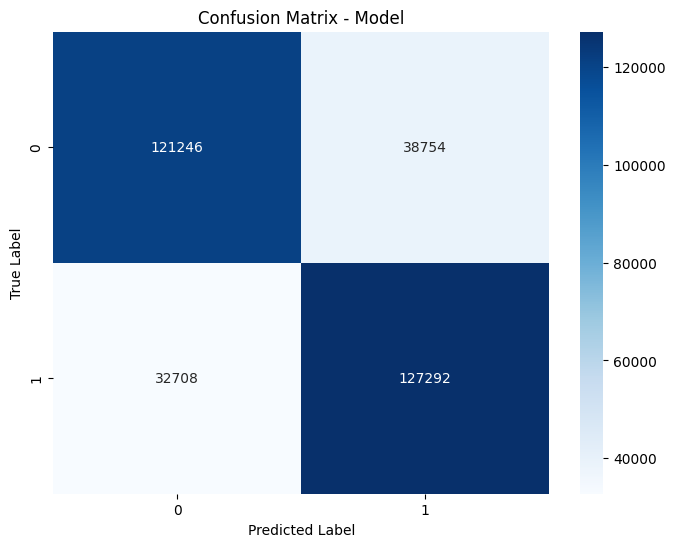


Cross-validation Scores: [0.7768125  0.77701562 0.77802734 0.77530078 0.77342578]
Average CV Score: 0.776 (+/- 0.003)


In [ ]:
evaluate_model(model, X_train, X_test, Y_train, Y_test)

In [ ]:
# Compare multiple models
def compare_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'Linear SVC': LinearSVC(max_iter=1000)
    }

    results = []
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time

        accuracy = accuracy_score(y_test, model.predict(X_test))
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Training Time': train_time
        })

    results_df = pd.DataFrame(results)

    # Plotting comparison
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y='Accuracy', data=results_df)
    plt.title('Model Comparison - Accuracy')
    plt.xticks(rotation=45)
    plt.show()

    return results_df



**Saving the train model**

In [ ]:
import pickle

In [ ]:
filename = 'trained_model.sav'
pickle.dump(model,open(filename,'wb'))

prediction

In [ ]:
#future prediction
loaded_model = pickle.load(open('trained_model.sav','rb'))

In [ ]:
def preprocess_and_predict(text, vectorizer, loaded_model):
    # Convert single text to list format
    stem_text = [stemming(text)]  # Make sure stemming() function is defined

    # Transform the text using the already fitted vectorizer
    # Don't use fit() here - the vectorizer should be already fitted on training data
    vectorized_text = vectorizer.transform(stem_text)

    # Make prediction
    prediction = loaded_model.predict(vectorized_text)

    if prediction[0] == 0:
        return 'The news is Negative'
    else:
        return 'The news is Positive'

In [ ]:
text = "hello, today is lol day"
print(preprocess_and_predict(text,vectorizer,loaded_model))

NameError: name 'vectorizer' is not defined

In [ ]:
# Function to make predictions on new tweets
def predict_sentiment(text, vectorizer, model):
    # Preprocess the text using the same stemming function
    processed_text = stemming(text)
    # Transform the text using the fitted vectorizer
    vectorized_text = vectorizer.transform([processed_text])
    # Make prediction
    prediction = model.predict(vectorized_text)
    probability = model.predict_proba(vectorized_text)[0]

    sentiment = "Positive" if prediction[0] == 1 else "Negative"
    confidence = probability[1] if prediction[0] == 1 else probability[0]

    return {
        'text': text,
        'sentiment': sentiment,
        'confidence': confidence
    }

In [ ]:
text = "hello, today is a bad day"
print(predict_sentiment(text,vectorizer,loaded_model))

NameError: name 'predict_sentiment' is not defined